# Combine GPX and UV track to yield a KML file

## Imports

In [1]:
import datetime
import gpxpy
import json
import matplotlib.dates as mdate
import matplotlib.pyplot as plt
import pytz
import sys
from simplekml import Kml


## Initial Settings

In [138]:
if False:
    xhour_start     = 8
    xhour_stop      = 21
    file_forecast   = "./data/2024-06-27_uv-forecast.json"
    file_uvbg       = "./data/2024-06-27_uvbg.csv"
    file_gpx        = "./data/2024-06-27_09-48.gpx"
    xtimedelta_gpx_sec = 7200
    img_outfilename =      "./2024-06-27_uvbg_Augsburg.png"
    kml_outfilename =      "./2024-06-27_uvbg_Augsburg.kml"
    xpointstyle     = "https://uv-bodyguard.de/ajuma_pin.png" # "http://maps.google.com/mapfiles/kml/shapes/road_shield3.png"


In [149]:
if False:
    xhour_start     = 7
    xhour_stop      = 20
    file_forecast   = "./data/2024-06-27_uv-forecast.json"
    file_uvbg       = "./data/2024-06-27_Rad_uvbg.csv"
    file_gpx        = "./data/2024-06-27_Rad_watch_MUC-AUX.gpx"
    xtimedelta_gpx_sec = 7200
    img_outfilename =      "./2024-06-27_Rad_watch_MUC_AUX.png"
    kml_outfilename =      "./2024-06-27_Rad_watch_MUC_AUX.kml"
    xpointstyle     = "https://uv-bodyguard.de/ajuma_pin.png" # "http://maps.google.com/mapfiles/kml/shapes/road_shield3.png"
    

In [153]:
if True:
    xhour_start     = 7
    xhour_stop      = 20
    file_forecast   = "./data/2024-06-27_uv-forecast.json"
    file_uvbg       = "./data/2024-06-27_Rad_uvbg.csv"
    file_gpx        = "./data/2024-06-27_Rad_watch_AUX-MUC.gpx"
    xtimedelta_gpx_sec = 7200
    img_outfilename =      "./2024-06-27_Rad_AUX_MUC.png"
    kml_outfilename =      "./2024-06-27_Rad_AUX_MUC.kml"
    xpointstyle     = "https://uv-bodyguard.de/ajuma_pin.png" # "http://maps.google.com/mapfiles/kml/shapes/road_shield3.png"
    

In [155]:
print (file_forecast, "\n", file_gpx, "\n", file_uvbg, "\n", img_outfilename, "\n", kml_outfilename, "\n")

./data/2024-06-27_uv-forecast.json 
 ./data/2024-06-27_Rad_watch_AUX-MUC.gpx 
 ./data/2024-06-27_Rad_uvbg.csv 
 ./2024-06-27_Rad_AUX_MUC.png 
 ./2024-06-27_Rad_AUX_MUC.kml 



## Functions

### Settings

In [3]:
colors=["ff007700", "ff00ff00", "ff00ff77", "ff0044ff", "ff007777", "ff00ffff", "ff0077ff", "ff0044ff", "ff0000ff", "ff7700ff", "ffff00ff"]

In [45]:
colors_UV=["#27ae60", "#ffcb45", "#ff8a35", "#ff3333", "#ff33fa"]

### Forecast

In [4]:
def howto_forecast():
    print ("wget https://ren27oydli.execute-api.eu-central-1.amazonaws.com/prod\?lon=11.5\&lat=48.5\&tz=-120\&secret=UV-Bodyguard -O `date +'%Y%m%d'`_uv-forecast.json")


In [5]:
# Web download from:
# https://ren27oydli.execute-api.eu-central-1.amazonaws.com/prod?lon=11.5&lat=48.5&tz=-120&secret=UV-Bodyguard
def read_forecast(file_forecast):
    file_forecast_handle = open (file_forecast, "r")
    uv_forecast = json.load(file_forecast_handle)["uv"]

    uv_forecast_dates = []
    uv_forecast_value = []

    for item in uv_forecast:
        uv_forecast_dates.append (datetime.datetime.fromtimestamp(int(item["time"])-7200))
        uv_forecast_value.append (float(item["value"]))
    
    return uv_forecast_dates, uv_forecast_value


### Read UVBG

In [18]:
def read_uvbg(file_uvbg):
    file_handle = open (file_uvbg, "r")
    lines = file_handle.readlines()
    file_handle.close()

    uvbg_dates = []
    uvbg_value = []
    uvtrack = []
    
    for line in lines:
        items = line.split(",")
        xtime_dt = datetime.datetime.fromtimestamp(int(items[0])/1000) # -7200)
        uvbg_dates.append(xtime_dt)
        xuvi = float(items[1])
        uvbg_value.append(xuvi)
        
        uvtrack.append({"time": xtime_dt.replace(tzinfo=pytz.UTC), "uvi": xuvi})
        
    x = uvbg_dates[0]
    xyyyy = int(x.strftime("%Y"))
    xmm = int(x.strftime("%m"))
    xdd = int(x.strftime("%d"))
    xtoday = datetime.datetime (xyyyy, xmm, xdd, 0, 0, 0)
    
    print ("UV Track: First/last: ", uvtrack[0]["time"], uvtrack[-1]["time"])
        
    return uvbg_dates, uvbg_value, xtoday, uvtrack


### Read GPX

In [112]:
def read_gpx(file_gpx):

    gpx = gpxpy.parse(open(file_gpx), "r")

    geotrack = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                geotrack.append({"time": point.time+datetime.timedelta(0,xtimedelta_gpx_sec), "lon": point.longitude, "lat": point.latitude, "elevation": point.elevation, "uvi": -1})
                # print('Point at ({0},{1},{2}) -> {3}'.format(point.time, point.latitude, point.longitude, point.elevation))
    
    print ("GPX track: First/last: ", geotrack[0]["time"], geotrack[-1]["time"])
    
    return geotrack


### Combine GPX and UV track

In [147]:
def combine_gpx_uvtrack(geotrack, uvtrack, kml_outfilename):
    
    nelements = len(geotrack)
    ielement  = 0
    
    print ("")
    
    for g in geotrack:
        print("\r", ielement/nelements*100, "%", end="")
              
        xgeotime = g["time"]

        xdeltat = []
        for uv in uvtrack:
            xdeltat.append (abs(uv["time"] - xgeotime))

        xmindeltat = min (xdeltat)
        i = xdeltat.index (xmindeltat)

        g["uvi"] = uvtrack[i]["uvi"]
              
        ielement += 1

    kml = Kml()
    fol = kml.newfolder(name="A Folder")
    
    print ("---> Achtung: Tracks werden um Faktor 30 reduziert! <---")
    
    counter = 0    
    for g in geotrack:
        counter = counter + 1
        if counter == 30:
            pnt = fol.newpoint(name="{0}".format(int(g["uvi"])), coords=[(g["lon"],g["lat"])])
            uv_index = int(g["uvi"])
            if uv_index > 11: uv_index = 11
            pnt.style.iconstyle.color = colors[uv_index] # float(float(uv_index) / 3.0)
            pnt.style.iconstyle.icon.href = xpointstyle
            # Shapes can be found here: https://kml4earth.appspot.com/icons.html#shapes
            counter = 0

    kml.save(kml_outfilename)
    
    print ("\n\nKML file written to ", kml_outfilename)
    
    print ("\nYou may use https://kmzview.com/ or https://earth.google.com for visualization of KML file.\n")
    

### Plot UVBG

In [98]:
def plot_uvbg(uvbg_dates, uvbg_value, xtoday):

    fig, ax = plt.subplots()
    
    # Filter for value-ranges
    uvbg_dates0 = []
    uvbg0 = []
    
    print (len(uvbg_dates))
    for (xdate,value) in zip(uvbg_dates, uvbg_value):
        if value < 3:
            uvbg_dates0.append(xdate)
            uvbg0.append(value)
    
    uvbg_dates1 = []
    uvbg1 = []
    for (xdate,value) in zip(uvbg_dates, uvbg_value):
        if 3 <= value and value < 6:
            uvbg_dates1.append(xdate)
            uvbg1.append(value)

    
    uvbg_dates2 = []
    uvbg2 = []
    for (xdate,value) in zip(uvbg_dates, uvbg_value):
        if 6 <= value and value < 9:
            uvbg_dates2.append(xdate)
            uvbg2.append(value)

    uvbg_dates3 = []
    uvbg3 = []
    for (xdate,value) in zip(uvbg_dates, uvbg_value):
        if 9 <= value:
            uvbg_dates3.append(xdate)
            uvbg3.append(value)    

    # Plot the date using plot_date rather than plot
    ax.plot_date(uvbg_dates0, uvbg0, ".", color=colors_UV[0])
    ax.plot_date(uvbg_dates1, uvbg1, ".", color=colors_UV[1])
    ax.plot_date(uvbg_dates2, uvbg2, ".", color=colors_UV[2])
    ax.plot_date(uvbg_dates3, uvbg3, ".", color=colors_UV[3])

    xtoday_min = xtoday + datetime.timedelta(0, xhour_start*60*60)
    xtoday_max = xtoday + datetime.timedelta(0, xhour_stop *60*60)
    
    ax.set_xlim(xtoday_min, xtoday_max)

    # Choose your xtick format string
    date_fmt = '%H:%M'

    # Use a DateFormatter to set the data to the correct format.
    # date_formatter = mdate.DateFormatter(date_fmt)
    # ax.xaxis.set_major_formatter(date_formatter)
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%H'))
    
    ax.set_title (xtoday.strftime("%Y-%m-%d"))
    ax.set_ylabel("Zeit")
    ax.set_ylabel("UV Index")

    # Sets the tick labels diagonal so they fit easier.
    fig.autofmt_xdate()
    
    fig.savefig(img_outfilename)
    print ("Image written to ", img_outfilename)
    

### Plot UVBG and Forecast

In [120]:
def plot_forecast_uvbg(uv_forecast_dates, uv_forecast_value, uvbg_dates, uvbg_value, xtoday):

    fig, ax = plt.subplots()
    
    # Filter for value-ranges
    uvbg_dates0 = []
    uvbg0 = []
    
    print (len(uvbg_dates))
    for (xdate,value) in zip(uvbg_dates, uvbg_value):
        if value < 3:
            uvbg_dates0.append(xdate)
            uvbg0.append(value)
    
    uvbg_dates1 = []
    uvbg1 = []
    for (xdate,value) in zip(uvbg_dates, uvbg_value):
        if 3 <= value and value < 6:
            uvbg_dates1.append(xdate)
            uvbg1.append(value)

    
    uvbg_dates2 = []
    uvbg2 = []
    for (xdate,value) in zip(uvbg_dates, uvbg_value):
        if 6 <= value and value < 9:
            uvbg_dates2.append(xdate)
            uvbg2.append(value)

    uvbg_dates3 = []
    uvbg3 = []
    for (xdate,value) in zip(uvbg_dates, uvbg_value):
        if 9 <= value:
            uvbg_dates3.append(xdate)
            uvbg3.append(value)    

    # Plot the date using plot_date rather than plot
    ax.plot_date(uvbg_dates0, uvbg0, ".", color=colors_UV[0])
    ax.plot_date(uvbg_dates1, uvbg1, ".", color=colors_UV[1])
    ax.plot_date(uvbg_dates2, uvbg2, ".", color=colors_UV[2])
    ax.plot_date(uvbg_dates3, uvbg3, ".", color=colors_UV[3])

    # Plot the date using plot_date rather than plot
    ax.plot_date(uv_forecast_dates, uv_forecast_value, "-", linewidth=3, color="grey")
#   ax.plot_date(uvbg_dates, uvbg_value, ".")

    xtoday_min = xtoday + datetime.timedelta(0, xhour_start*60*60)
    xtoday_max = xtoday + datetime.timedelta(0, xhour_stop *60*60)
    
    ax.set_xlim(xtoday_min, xtoday_max)

    # Choose your xtick format string
    date_fmt = '%H:%M'

    # Use a DateFormatter to set the data to the correct format.
    # date_formatter = mdate.DateFormatter(date_fmt)
    # ax.xaxis.set_major_formatter(date_formatter)
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%H'))
    
    ax.set_title (xtoday.strftime("%Y-%m-%d"))
    ax.set_ylabel("Zeit")
    ax.set_ylabel("UV Index")

    # Sets the tick labels diagonal so they fit easier.
    fig.autofmt_xdate()
    
    fig.savefig(img_outfilename)
    print ("Image written to ", img_outfilename)
    

## Main

wget https://ren27oydli.execute-api.eu-central-1.amazonaws.com/prod\?lon=11.5\&lat=48.5\&tz=-120\&secret=UV-Bodyguard -O `date +'%Y%m%d'`_uv-forecast.json
UV Track: First/last:  2024-06-27 03:55:54.180000+00:00 2024-06-27 22:23:28.101000+00:00
39557
Image written to  ./2024-06-27_Rad_AUX_MUC.png
GPX track: First/last:  2024-06-27 15:01:50+00:00 2024-06-27 17:44:41+00:00

 99.9874087131705 %Achtung: Tracks werden um Faktor reduziert!


KML file written to  ./2024-06-27_Rad_AUX_MUC.kml

You may use https://kmzview.com/ or https://earth.google.com for visualization of KML file.



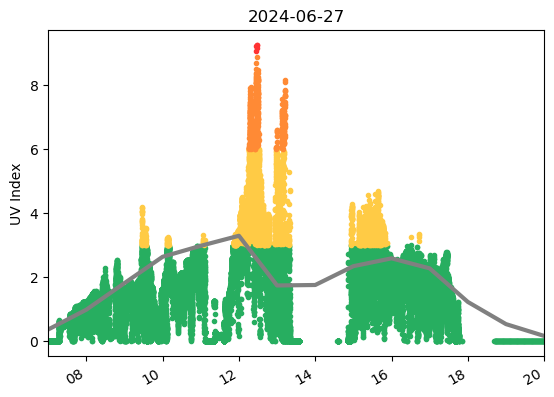

In [154]:
howto_forecast()
uv_forecast_dates, uv_forecast_value = read_forecast(file_forecast)
uvbg_dates, uvbg_value, xtoday, uvtrack = read_uvbg(file_uvbg)
plot_forecast_uvbg(uv_forecast_dates, uv_forecast_value, uvbg_dates, uvbg_value, xtoday)
geotrack = read_gpx(file_gpx)
# plot_uvbg(uvbg_dates, uvbg_value, xtoday)

combine_gpx_uvtrack(geotrack, uvtrack, kml_outfilename)


39557
Image written to  ./2024-06-27_Rad_MUC_AUX.png


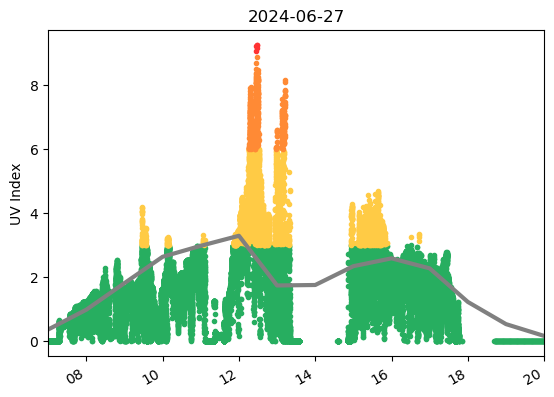

In [121]:
plot_forecast_uvbg(uv_forecast_dates, uv_forecast_value, uvbg_dates, uvbg_value, xtoday)

39557
Image written to  ./2024-06-27_Rad_AUX_MUC.png


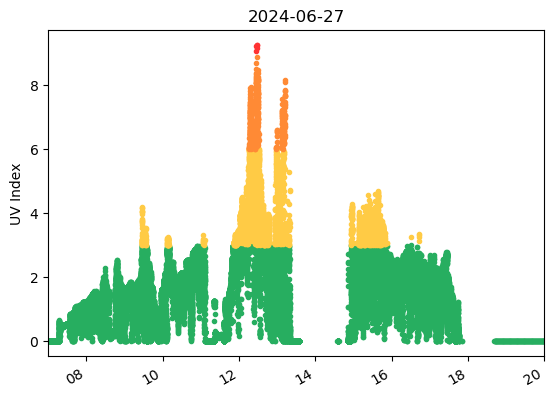

In [102]:
plot_uvbg(uvbg_dates, uvbg_value, xtoday)